In [2]:
from utils.loader import Loader
from utils.plot_res import plotpkl
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import torch
import numpy as np
import pandas as pd
import pickle

## Load Pretrained Models

In [3]:
folder = '2020-12-05-141456'
with open(f'checkpoint/{folder}/hyperparam.pkl', 'rb') as f:
    args = pickle.load(f)  
device = torch.device('cuda:0')
loader = Loader(args, device)
model = loader.load_model(folder=folder, model_name='best_v')
# plotpkl(f'checkpoint/{folder}/loss_log_dict.pkl', 'Experiment')

## Generate Grid Data and Predict their Scores

In [11]:
width_ranges = list(range(300,1200,100))
band_ranges = [b/100 for b in list(range(30,101,5))]
nbars = list(range(5, 31))
width_grid = loader.minmax(np.array(width_ranges), 'width')
bandwidth_grid = loader.minmax(np.array(band_ranges), 'bandwidth')
b_g, w_g = np.meshgrid(bandwidth_grid, width_grid)
paras = list(zip(b_g.flatten(), w_g.flatten()))
origindim = {
    'nbar': nbars,
    'bandwidth': band_ranges,
    'width': width_ranges,
    'aspectRatio': [x/300 for x in width_ranges]
}
param_list = []
for nbar in nbars:
    nnbar = loader.minmax(nbar, 'nbar')
    param_list += [torch.FloatTensor([x[1], nnbar, x[0]]).to(device) for x in paras]
dataset = torch.stack(param_list)

In [25]:
names = list(range(dataset.shape[0]))
results = model.assess(dataset, names) # make prediction
record = pd.DataFrame()                # organize result
record['score'] = [res[1] for res in results]
record['idx'] = names
record['nbar'] = dataset[:,1].detach().cpu()
record['width'] = dataset[:,0].detach().cpu()
record['bandwidth'] = dataset[:,2].detach().cpu()
record = loader.batch_denormalize(record)
# record = record.astype({'width': 'int32', 'nbar': 'int32'})
record['aspectRatio'] = record['width'].apply(lambda x: x / 300)
record.corr()

,score,idx,nbar,width,bandwidth,aspectRatio
score,1.000000,-0.190176,-1.952255e-01,8.536086e-02,3.850914e-01,8.536086e-02
idx,-0.190176,1.000000,9.992601e-01,3.822339e-02,4.263997e-03,3.822339e-02
nbar,-0.195226,0.999260,1.000000e+00,-6.877657e-17,2.967441e-18,1.157218e-16
width,0.085361,0.038223,-6.877657e-17,1.000000e+00,1.524315e-17,1.000000e+00
bandwidth,0.385091,0.004264,2.967441e-18,1.524315e-17,1.000000e+00,2.551866e-19
aspectRatio,0.085361,0.038223,1.157218e-16,1.000000e+00,2.551866e-19,1.000000e+00


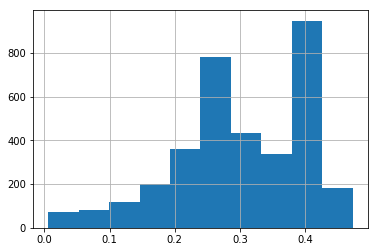

In [26]:
record['score'].hist()

In [27]:
def scatter(df, xaxis='nbar', yaxis='score', color=None):
    data = df
    if color is not None:
        data[color] = df[color].astype('str')
    px.scatter(data, x=xaxis, y=yaxis, color=color, marginal_y="box").show()
                
def heatmap(record, xaxis='nbar', yaxis='width', aggr='mean'):
    xx = origindim[xaxis]
    yy = origindim[yaxis]
    df = record
    eps = 0.01
    if aggr is 'max':
        data = [[df[(abs(df[xaxis]-x)<eps) & (abs(df[yaxis]-y)<eps)]['score'].max() for x in xx] for y in yy]
    elif aggr is 'mean':
        data = [[df[(abs(df[xaxis]-x)<eps) & (abs(df[yaxis]-y)<eps)]['score'].mean() for x in xx] for y in yy]
    elif aggr is 'min':
        data = [[df[(abs(df[xaxis]-x)<eps) & (abs(df[yaxis]-y)<eps)]['score'].min() for x in xx] for y in yy]
    else:
        return
    fig = go.Figure(data=go.Heatmap(
        z=data,
        x=xx,
        y=yy,
        colorscale='Emrld'))
    fig.update_layout(xaxis_title=xaxis, yaxis_title=yaxis)  
    fig.show()
    return fig    

In [28]:
fig=heatmap(record[record.nbar == 20], xaxis='aspectRatio', yaxis='bandwidth', aggr='max')

In [22]:
for nbar in list(range(5,35,5)):
#     heatmap(record, xaxis='width', yaxis='bandwidth', fix='nbar', fixv=15)
    heatmap(record[record.nbar == nbar], xaxis='width', yaxis='bandwidth', aggr='mean')